In [369]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

train_data= pd.read_csv('/Users/asthagupta/Desktop/coding/Python/deep_learning_scratch/MNIST/mnist_train.csv')
test_data= pd.read_csv('/Users/asthagupta/Desktop/coding/Python/deep_learning_scratch/MNIST/mnist_test.csv')


In [370]:
# batch generator
def batch_generator(data, batch_size, num_epochs):
    current_epoch = 0
    
    while current_epoch < num_epochs:
        shuffled_data = data.sample(frac=1).reset_index(drop=True)
        num_samples = len(shuffled_data)
        no_of_batches = num_samples // batch_size
        
        for batch_idx in range(no_of_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)
            batch = shuffled_data.iloc[start_idx:end_idx]
            
            
            x = (batch.drop(columns=['label']).values.T)/255  
            y = batch['label'].values
            
            yield x, y, current_epoch ,batch_idx
            
        current_epoch += 1

X[feature matrix] ~ 784 * m

w1[weight matrix_1] ~ 16 * 784

b1[bias matrix_1] ~ 16 * 1

w2[weight matrix_2] ~ 10 * 16

b2[bias matrix_2] ~ 10 * 1

I have used He initialization for the weight matrices,

where the variance is:

$$
\text{Variance} = \frac{2}{\text{Number of neurons in the input layer}}.
$$

The standard deviation is:

$$
\text{Standard Deviation} = \sqrt{\frac{2}{784}} \approx 0.05,
$$

and the mean is centralized (between -0.5 and 0.5).


In [371]:
# initial parameters
def parameter_initialization():
    W1 = np.random.randn(16,784)*0.05
    W2 = np.random.randn(10, 16)*0.05
    b1 = np.random.randn(16,1)-0.5
    b2 = np.random.randn(10,1)-0.5
    return W1, W2, b1, b2

In [372]:
# relu function
def relu(x):
    return np.maximum(0, x)

# derivative of relu
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

We subtract `np.max(x)` to maintain stability.

Mathematically, 

$$
 A_2 = \frac{\exp(x_i - a)}{\sum \exp(x_j - a)} = \frac{\exp(x_i)}{\sum \exp(x_j)}
$$

where \( a = max(x) \).

The argument `keepdims=True` keeps the original dimensions maintained and produces a row matrix.

The Softmax function is used to convert the raw outputs (logits) of the neural network into a probability distribution. The output probabilities \( A_2 \) for each class are computed as:



In [373]:
# softmax function
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=0, keepdims=True)

In [374]:
# one hot encoding
def one_hot_encode(y, m):
    y_encoded = np.zeros((10,m))
    y_encoded[y, np.arange(m)] = 1
    return y_encoded

In [375]:
# forward propagation
def forward(x, W1, b1, W2, b2):
    Z1=np.dot(W1,x)+b1
    A1=relu(Z1)
    Z2=np.dot(W2,A1)+b2
    A2=softmax(Z2)
    return A1, A2,Z1,Z2


Since this is a multiclass classification, I have used **Cross-Entropy Loss**. The Cross-Entropy Loss for a single example is:

$$
L = - \sum_{j=1}^{K} y_j \log(A_j)
$$

The gradient of the loss with respect to \( A_j \) is:

$$
\frac{\partial L}{\partial A_j} = - \frac{y_j}{A_j}
$$

The derivative of the Softmax function with respect to \( z_j \) is:

$$
\frac{\partial A_j}{\partial z_i} = 
\begin{cases}
A_j (1 - A_j) & \text{if } i = j \\
-A_i A_j & \text{if } i \neq j
\end{cases}
$$

Now, applying the chain rule:

$$
\frac{\partial L}{\partial z_j} = \sum_{i=1}^{K} \frac{\partial L}{\partial A_i} \frac{\partial A_i}{\partial z_j}
$$


$$
\frac{\partial L}{\partial z_j} = \sum_{i=1}^{K} \left( - \frac{y_i}{A_i} \right) \cdot \frac{\partial A_i}{\partial z_j}
$$


$$
\frac{\partial L}{\partial z_j} = A_j - y_j
$$

Thus, the gradient of the loss with respect to the logits is:

$$
dZ_2 = A_2 - y
$$


In [376]:
# backward propagation
def backward(x, y, A1, A2, W2, Z1, Z2,m):
    
    dZ2 = A2 - y
    dW2 = 1/m*np.dot(dZ2,A1.T) 
    db2 = 1/m*np.sum(dZ2, axis=1, keepdims=True) 

    dZ1 = np.dot(W2.T,dZ2 ) * relu_derivative(Z1)
    dW1 = 1/m*np.dot(dZ1, x.T) 
    db1 = 1/m*np.sum(dZ1, axis=1, keepdims=True) 
    return dW1, db1, dW2, db2

In [377]:
# stochastic gradient descent
def stochastic_gradient_descent(W1, b1, W2, b2, batch_size, train_data, epochs, learning_rate):
    no_of_batches = len(train_data) // batch_size
    generator = batch_generator(train_data, batch_size, epochs)
    correct_predictions = 0
    total_predictions = 0
    A=[]
    E=[]
    for x, y, current_epoch, batch_idx in generator:
            batch_size = x.shape[1]
            
            y = one_hot_encode(y, batch_size)
            A1, A2, Z1, Z2 = forward(x, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backward(x, y, A1, A2, W2, Z1, Z2, batch_size)
            
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
            
            predicted = np.argmax(A2, axis=0)
            actual = np.argmax(y, axis=0)
            correct_predictions += np.sum(predicted == actual)
            total_predictions += batch_size
            accuracy = correct_predictions / total_predictions
            if batch_idx == no_of_batches-1:
                        print(f"Epoch {current_epoch + 1},Accuracy: {accuracy * 100:.2f}%")
                        A.append(accuracy)
                        E.append(current_epoch + 1)
                        correct_predictions= 0
                        total_predictions= 0
    print(f"Final Accuracy: {accuracy * 100:.2f}%")
    return W1, b1, W2, b2 , A, E

In [378]:
# stochastic gradient with momentum
def stochastic_momentum(W1, b1, W2, b2, batch_size, train_data, epochs, learning_rate, beta):
    no_of_batches = len(train_data) // batch_size
    mW1, mb1 = np.zeros_like(W1), np.zeros_like(b1)
    mW2, mb2 = np.zeros_like(W2), np.zeros_like(b2)

    generator = batch_generator(train_data, batch_size, epochs)
    B=[]
    E=[]
    for epoch in range(epochs):
        correct_predictions = 0
        total_predictions = 0
        
        for x, y, current_epoch, batch_idx in generator:
            m = x.shape[1]
            y_encoded = one_hot_encode(y, m)
            A1, A2, Z1, Z2 = forward(x, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backward(x, y_encoded, A1, A2, W2, Z1, Z2, m)

            mW1 = beta * mW1 + dW1
            mb1 = beta * mb1 + db1
            mW2 = beta * mW2 + dW2
            mb2 = beta * mb2 + db2

            W1 -= learning_rate * mW1
            b1 -= learning_rate * mb1
            W2 -= learning_rate * mW2
            b2 -= learning_rate * mb2

            predictions = np.argmax(A2, axis=0)
            actual = np.argmax(y_encoded, axis=0)
            correct_predictions += np.sum(predictions == actual)
            total_predictions += m
            accuracy = correct_predictions / total_predictions
            if batch_idx == no_of_batches-1:
                        print(f"Epoch {current_epoch + 1},Accuracy: {accuracy * 100:.2f}%")
                        B.append(accuracy)
                        E.append(current_epoch + 1)
                        correct_predictions= 0
                        total_predictions= 0
            
    print(f"Final Accuracy: {accuracy * 100:.2f}%")
    return W1,b1,W2,b2, B, E

In [379]:
# adaptive gradient descent
def stochastic_adagrad(W1, b1, W2, b2, batch_size, train_data, epochs,learning_rate,epsilon):
    no_of_batches = len(train_data) // batch_size
    generator = batch_generator(train_data, batch_size, epochs)
    
    mW1 = np.zeros_like(W1)
    mb1 = np.zeros_like(b1)
    mW2 = np.zeros_like(W2)
    mb2 = np.zeros_like(b2)
    
    C=[]
    E=[]
    for epoch in range(epochs):
        correct_predictions = 0
        total_predictions = 0
        for x, y, current_epoch, batch_idx in generator:
            batch_size = x.shape[1]
            y = one_hot_encode(y, batch_size)
            A1, A2, Z1, Z2 = forward(x, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backward(x, y, A1, A2, W2, Z1, Z2,batch_size)
            
            mW1 = mW1 + dW1 * dW1
            mb1 = mb1 + db1 * db1
            mW2 = mW2 + dW2 * dW2
            mb2 = mb2 + db2 * db2
            
            W1 -= ((learning_rate)/(epsilon+np.sqrt(mW1))) * dW1
            b1 -= ((learning_rate)/(epsilon+np.sqrt(mb1))) * db1
            W2 -= ((learning_rate)/(epsilon+np.sqrt(mW2))) * dW2
            b2 -= ((learning_rate)/(epsilon+np.sqrt(mb2))) * db2
            
            predicted = np.argmax(A2, axis=0)
            actual = np.argmax(y, axis=0)
            correct_predictions += np.sum(predicted == actual)
            total_predictions += batch_size
            accuracy = correct_predictions / total_predictions
            if batch_idx == no_of_batches-1:
                        print(f"Epoch {current_epoch + 1},Accuracy: {accuracy * 100:.2f}%")
                        C.append(accuracy)
                        E.append(current_epoch + 1)
                        correct_predictions= 0
                        total_predictions= 0
    print(f"Final Accuracy: {accuracy * 100:.2f}%")
    return W1,b1,W2,b2, C, E

In [380]:
# Root Mean Square Propagation
def rmsprop(W1, b1, W2, b2, batch_size, train_data, epochs, learning_rate, beta, epsilon):
    no_of_batches = len(train_data) // batch_size
    
    sW1, sb1 = np.zeros_like(W1), np.zeros_like(b1)
    sW2, sb2 = np.zeros_like(W2), np.zeros_like(b2)

    generator = batch_generator(train_data, batch_size, epochs)
    
    D=[]
    E=[]
    for epoch in range(epochs):
        correct_predictions = 0
        total_predictions = 0
        
        for x, y, current_epoch, batch_idx in generator:
            m = x.shape[1]
            y_encoded = one_hot_encode(y, m)
            A1, A2, Z1, Z2 = forward(x, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backward(x, y_encoded, A1, A2, W2, Z1, Z2, m)

            sW1 = beta * sW1 + (1 - beta) * (dW1 ** 2)
            sb1 = beta * sb1 + (1 - beta) * (db1 ** 2)
            sW2 = beta * sW2 + (1 - beta) * (dW2 ** 2)
            sb2 = beta * sb2 + (1 - beta) * (db2 ** 2)

            W1 -= learning_rate * dW1 / (np.sqrt(sW1) + epsilon)
            b1 -= learning_rate * db1 / (np.sqrt(sb1) + epsilon)
            W2 -= learning_rate * dW2 / (np.sqrt(sW2) + epsilon)
            b2 -= learning_rate * db2 / (np.sqrt(sb2) + epsilon)

            predictions = np.argmax(A2, axis=0)
            actual = np.argmax(y_encoded, axis=0)
            correct_predictions += np.sum(predictions == actual)
            total_predictions += m
            accuracy = correct_predictions / total_predictions
            if batch_idx == no_of_batches-1:
                        print(f"Epoch {current_epoch + 1},Accuracy: {accuracy * 100:.2f}%")
                        D.append(accuracy)
                        E.append(current_epoch + 1)
                        correct_predictions= 0
                        total_predictions= 0
    return W1, b1, W2, b2, D, E

In [381]:
# adaptive gradient descent with stochastic momentum
def stochastic_adam_optimizer(W1, b1, W2, b2, batch_size, train_data, epochs, learning_rate, beta1, beta2, epsilon):
    
    no_of_batches = len(train_data) // batch_size

    mW1, vW1 = np.zeros_like(W1), np.zeros_like(W1)
    mW2, vW2 = np.zeros_like(W2), np.zeros_like(W2)
    mb1, vb1 = np.zeros_like(b1), np.zeros_like(b1)
    mb2, vb2 = np.zeros_like(b2), np.zeros_like(b2)
    generator = batch_generator(train_data, batch_size, epochs)
    
    t = 0 
    
    F=[]
    E=[]
    for epoch in range(epochs):
        correct_predictions = 0
        total_predictions = 0
    
        for x, y, current_epoch, batch_idx in generator:
    
            m = x.shape[1]
            y_encoded = one_hot_encode(y, m)
    
            A1, A2, Z1, Z2 = forward(x, W1, b1, W2, b2)
    
            dW1, db1, dW2, db2 = backward(x, y_encoded, A1, A2, W2, Z1, Z2, m)
    
            mW1 = beta1 * mW1 + (1 - beta1) * dW1
            vW1 = beta2 * vW1 + (1 - beta2) * (dW1 ** 2)
            mb1 = beta1 * mb1 + (1 - beta1) * db1
            vb1 = beta2 * vb1 + (1 - beta2) * (db1 ** 2)
            mW2 = beta1 * mW2 + (1 - beta1) * dW2
            vW2 = beta2 * vW2 + (1 - beta2) * (dW2 ** 2)
            mb2 = beta1 * mb2 + (1 - beta1) * db2
            vb2 = beta2 * vb2 + (1 - beta2) * (db2 ** 2)
    
            t += 1
    
            mW1_hat = mW1 / (1 - beta1 ** (t))
            vW1_hat = vW1 / (1 - beta2 ** (t))
            mb1_hat = mb1 / (1 - beta1 ** (t))
            vb1_hat = vb1 / (1 - beta2 ** (t))
            mW2_hat = mW2 / (1 - beta1 ** (t))
            vW2_hat = vW2 / (1 - beta2 ** (t))
            mb2_hat = mb2 / (1 - beta1 ** (t))
            vb2_hat = vb2 / (1 - beta2 ** (t))
    
            W1 -= learning_rate * mW1_hat / (np.sqrt(vW1_hat) + epsilon)
            b1 -= learning_rate * mb1_hat / (np.sqrt(vb1_hat) + epsilon)
            W2 -= learning_rate * mW2_hat / (np.sqrt(vW2_hat) + epsilon)
            b2 -= learning_rate * mb2_hat / (np.sqrt(vb2_hat) + epsilon)
    
            predictions = np.argmax(A2, axis=0)
            actual = np.argmax(y_encoded, axis=0)
            correct_predictions += np.sum(predictions == actual)
            total_predictions += m
            accuracy = correct_predictions / total_predictions
            if batch_idx == no_of_batches-1:
                        print(f"Epoch {current_epoch + 1},Accuracy: {accuracy * 100:.2f}%")
                        F.append(accuracy)
                        E.append(current_epoch + 1)
                        correct_predictions= 0
                        total_predictions= 0
    
    print(f"Final Accuracy: {accuracy * 100:.2f}%")
    return W1, b1, W2, b2, F, E

In [382]:
# predict function 
def predict(W1, b1, W2, b2):
    testing_data=pd.read_csv('/Users/asthagupta/Desktop/coding/Python/deep_learning_scratch/MNIST/mnist_test.csv')
    x= (testing_data.drop(columns=['label']).values.T)/255
    y= testing_data['label'].values.T
    A1, A2, Z1, Z2 = forward(x, W1, b1, W2, b2)
    predicted = np.argmax(A2, axis=0)
    actual = y
    correct_predictions = np.sum(predicted == actual)
    incorrect_predictions = np.where(predicted != actual)[0]
    total_predictions = len(actual)
    accuracy = correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    plt.imshow(x[:, incorrect_predictions[40]].reshape(28, 28), cmap='Blues')
    plt.title(f"Actual: {actual[incorrect_predictions[40]]}, Predicted: {predicted[incorrect_predictions[40]]}")
    plt.show()
    plt.imshow(x[:, incorrect_predictions[20]].reshape(28, 28), cmap='gray')
    plt.title(f"Actual: {actual[incorrect_predictions[20]]}, Predicted: {predicted[incorrect_predictions[20]]}")
    plt.show()
    plt.imshow(x[:, incorrect_predictions[60]].reshape(28, 28), cmap='Blues')
    plt.title(f"Actual: {actual[incorrect_predictions[60]]}, Predicted: {predicted[incorrect_predictions[60]]}")
    plt.show()


Epoch 1,Accuracy: 41.29%
Epoch 2,Accuracy: 75.64%
Epoch 3,Accuracy: 84.62%
Epoch 4,Accuracy: 87.25%
Epoch 5,Accuracy: 88.50%
Epoch 6,Accuracy: 89.21%
Epoch 7,Accuracy: 89.71%
Epoch 8,Accuracy: 90.01%
Epoch 9,Accuracy: 90.25%
Epoch 10,Accuracy: 90.45%
Final Accuracy: 90.45%
Test Accuracy: 90.86%


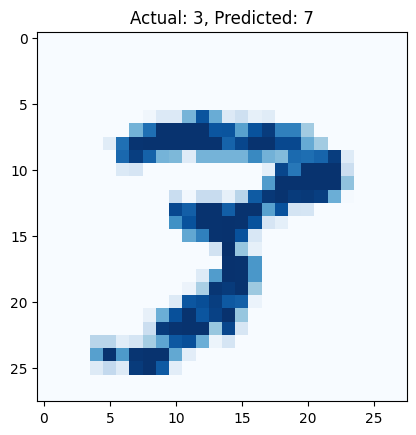

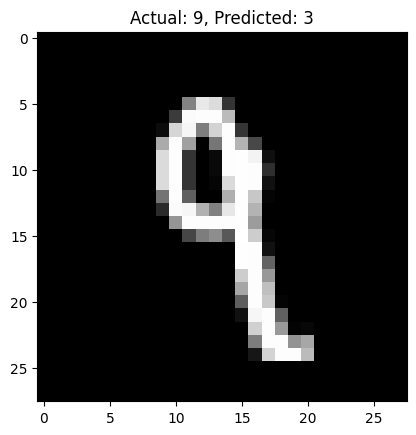

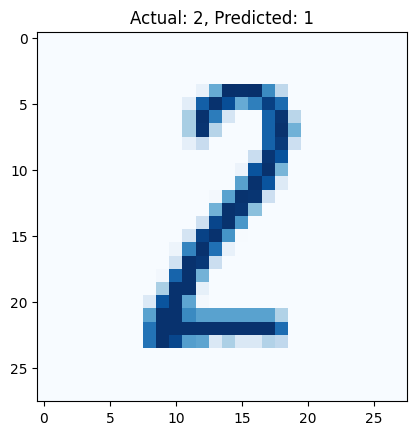

In [383]:
# running SGD
W1, W2, b1, b2= parameter_initialization()
W1,b1,W2,b2,A,E=stochastic_gradient_descent(W1, b1, W2, b2, 64, train_data, 10, learning_rate=0.01)
# testing the model
predict(W1, b1, W2, b2)

Epoch 1,Accuracy: 47.69%
Epoch 2,Accuracy: 77.01%
Epoch 3,Accuracy: 84.38%
Epoch 4,Accuracy: 87.59%
Epoch 5,Accuracy: 88.81%
Epoch 6,Accuracy: 89.46%
Epoch 7,Accuracy: 89.90%
Epoch 8,Accuracy: 90.26%
Epoch 9,Accuracy: 90.56%
Epoch 10,Accuracy: 90.75%
Final Accuracy: 90.75%
Test Accuracy: 91.25%


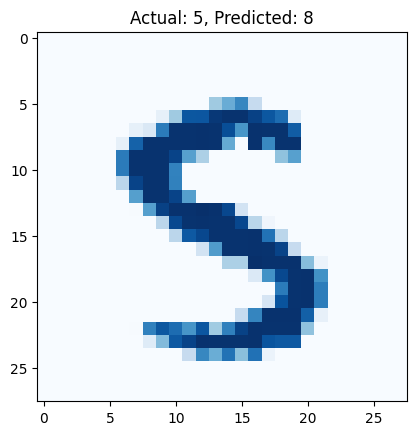

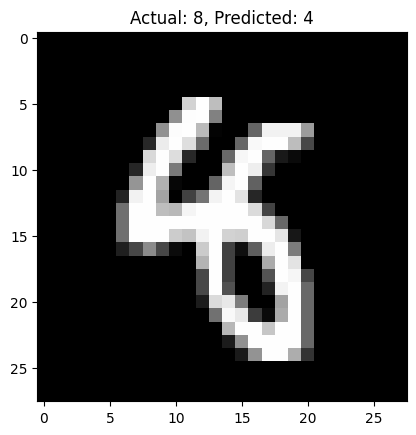

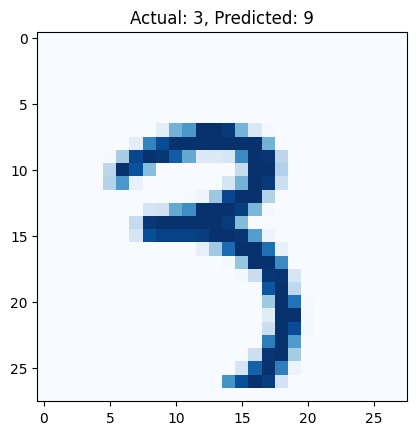

In [384]:
# running momentum
W1, W2, b1, b2= parameter_initialization()
W1,b1,W2,b2,B,E=stochastic_momentum(W1, b1, W2, b2, 64, train_data, 10, learning_rate=0.001, beta=0.9)
# testing the model
predict(W1, b1, W2, b2)

Epoch 1,Accuracy: 26.95%
Epoch 2,Accuracy: 52.80%
Epoch 3,Accuracy: 62.33%
Epoch 4,Accuracy: 70.90%
Epoch 5,Accuracy: 76.60%
Epoch 6,Accuracy: 79.14%
Epoch 7,Accuracy: 80.50%
Epoch 8,Accuracy: 81.42%
Epoch 9,Accuracy: 82.11%
Epoch 10,Accuracy: 82.69%
Final Accuracy: 82.69%
Test Accuracy: 83.55%


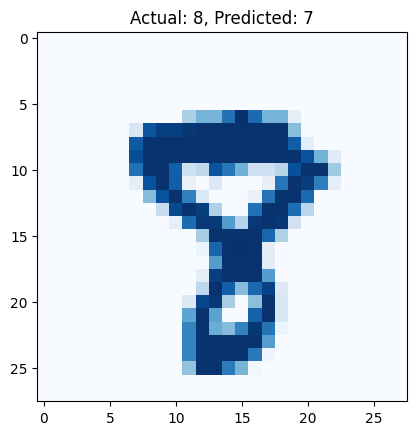

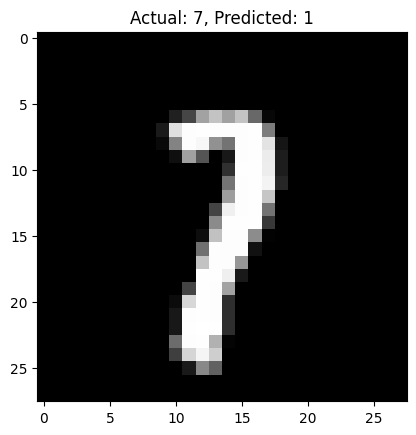

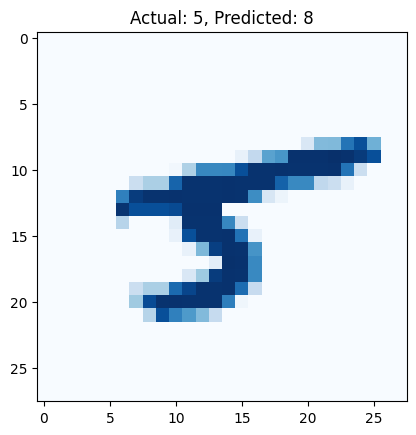

In [385]:
# running adagrad
W1, W2, b1, b2= parameter_initialization()
W1,b1,W2,b2,C,E=stochastic_adagrad(W1, b1, W2, b2, 64, train_data, 10, learning_rate=0.001,epsilon=1e-8)
# testing the model
predict(W1, b1, W2, b2)


Epoch 1,Accuracy: 79.03%
Epoch 2,Accuracy: 90.67%
Epoch 3,Accuracy: 91.84%
Epoch 4,Accuracy: 92.48%
Epoch 5,Accuracy: 92.92%
Epoch 6,Accuracy: 93.26%
Epoch 7,Accuracy: 93.52%
Epoch 8,Accuracy: 93.69%
Epoch 9,Accuracy: 93.86%
Epoch 10,Accuracy: 94.00%
Test Accuracy: 93.71%


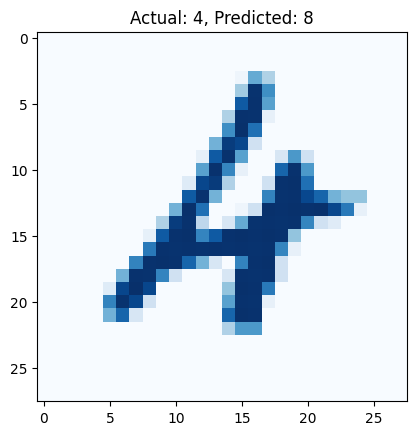

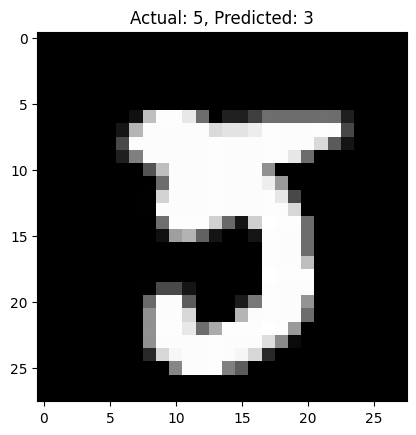

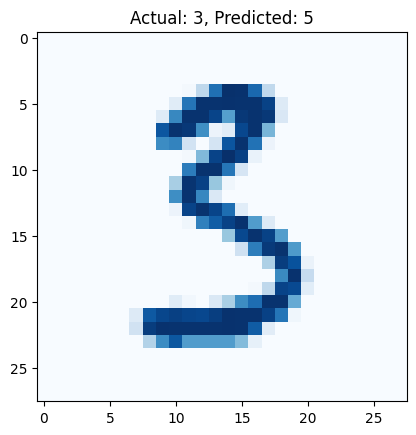

In [386]:

# running rmsprop
W1, W2, b1, b2= parameter_initialization()
W1,b1,W2,b2,D,E=rmsprop(W1, b1, W2, b2, 64, train_data, 10, learning_rate=0.001, beta=0.9, epsilon=1e-8)
# testing the model
predict(W1, b1, W2, b2)

Epoch 1,Accuracy: 77.12%
Epoch 2,Accuracy: 90.58%
Epoch 3,Accuracy: 91.77%
Epoch 4,Accuracy: 92.33%
Epoch 5,Accuracy: 93.05%
Epoch 6,Accuracy: 93.46%
Epoch 7,Accuracy: 93.79%
Epoch 8,Accuracy: 93.80%
Epoch 9,Accuracy: 94.00%
Epoch 10,Accuracy: 94.15%
Final Accuracy: 94.15%
Test Accuracy: 93.81%


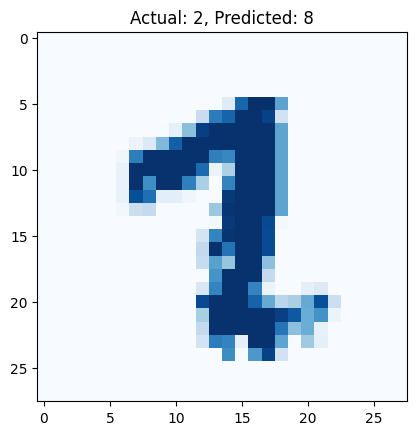

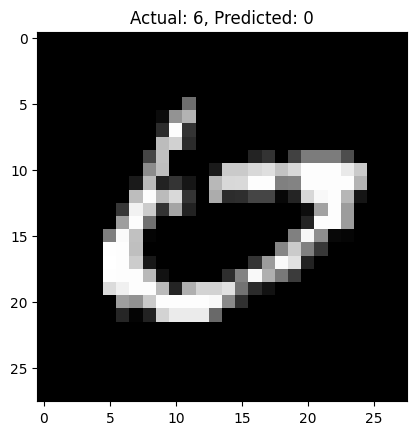

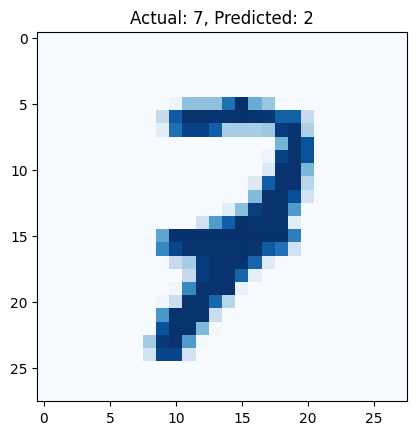

In [387]:
# Run Adam optimization with sgd
W1, W2, b1, b2= parameter_initialization()
W1,b1,W2,b2,F,E=stochastic_adam_optimizer(W1, b1, W2, b2, 64, train_data, 10, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8)
# testing the model
predict(W1, b1, W2, b2)

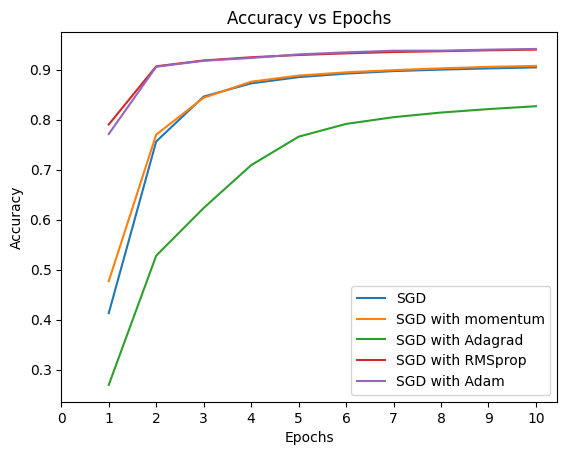

In [389]:
plt.plot(E,A, label='SGD')
plt.plot(E,B, label='SGD with momentum')
plt.plot(E,C, label='SGD with Adagrad')
plt.plot(E,D, label='SGD with RMSprop')
plt.plot(E,F, label='SGD with Adam')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, 11, 1))
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()